In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

In [0]:
#Settings
NUM_EPOCHS = 15
BATCH_SIZE = 256
LEARNING_RATE = 0.001

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


In [0]:
train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32)/255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32)/255.

train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

In [7]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28, 1) float32
(60000,) int32
(10000, 28, 28, 1) float32
(10000,) int32


In [0]:
test_samples = train_x[:100,...]

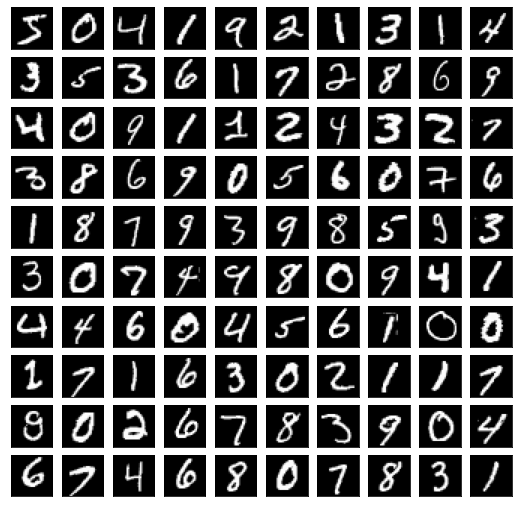

In [9]:
fig = plt.figure(figsize = (9, 9))
for j in range(test_samples.shape[0]):
    ax = fig.add_subplot(10, 10, j+1)
    ax.imshow(test_samples[j,:,:,0], cmap = "gray")
    plt.xticks([]),plt.yticks([])
plt.show()    

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [0]:
train_ds = train_ds.shuffle(buffer_size = train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [0]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        self.Conv1 = tf.compat.v1.layers.Conv2D(32, (5, 5), activation= tf.nn.relu, padding= "same")
        self.Conv2 = tf.compat.v1.layers.Conv2D(64, (5, 5), activation= tf.nn.relu, padding= "same")
        self.Fc1 = tf.compat.v1.layers.Dense(256, activation= tf.nn.sigmoid)
        self.Fc2 = tf.compat.v1.layers.Dense(10, activation= tf.nn.softmax)
        self.MaxPooling = tf.compat.v1.layers.MaxPooling2D((2, 2), (2, 2), padding="same")

    def __call__(self, inp):
        out = self.Conv1(inp)
        out = self.MaxPooling(out)
        out = self.Conv2(out)
        out = self.MaxPooling(out)
        out = tf.compat.v1.layers.flatten(out)
        out = self.Fc1(out)
        out = self.Fc2(out)
        return out

In [0]:
model = Model()

In [0]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [0]:
#optimizer = tf.compat.v1.train.GradientDescentOptimizer(LEARNING_RATE)
optimizer = tf.compat.v1.train.AdamOptimizer(LEARNING_RATE)

In [0]:
global_step = tf.compat.v1.train.get_or_create_global_step()

In [17]:
%%time

for (images, labels) in train_ds:

    #Forward
    
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    #Backward
    
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

    if global_step.numpy() % 200 == 0:
        test_logits = model(test_x[:512, ...])
        accuracy_value = accuracy(test_logits, test_y[:512, ...])
        print(f"[{global_step.numpy()}] Accuracy {accuracy_value.numpy()*100}")  

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
[200] Accuracy 97.4609375
[400] Accuracy 98.6328125
[600] Accuracy 98.4375
[800] Accuracy 99.21875
[1000] Accuracy 99.21875
[1200] Accuracy 98.6328125
[1400] Accuracy 99.4140625
[1600] Accuracy 99.21875
[1800] Accuracy 99.4140625
[2000] Accuracy 99.8046875
[2200] Accuracy 99.4140625
[2400] Accuracy 99.609375
[2600] Accuracy 99.4140625
[2800] Accuracy 99.609375
[3000] Accuracy 99.21875
[3200] Accuracy 99.4140625
[3400] Accuracy 99.4140625
CPU times: user 43.8 s, sys: 2.4 s, total: 46.2 s
Wall time: 1min 11s


In [18]:
test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print(f"Final Acc:{accuracy_value*100}%")

Final Acc:99.22999739646912%


In [0]:
def test_digit(sample):
    sample = sample[np.newaxis, ...]
    logits = model(sample)
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[0, :, :, 0], cmap="gray")
    plt.xticks([]), plt.xticks([])
    
    ax = fig.add_subplot(1,2,2)
    bar_list = ax.bar(np.arange(10), prediction[0], align = "center")
    bar_list[ans].set_color("g")
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1,10])
    ax.grid(True)
    
    plt.show()
    
    print(f"Predicted:{ans}")

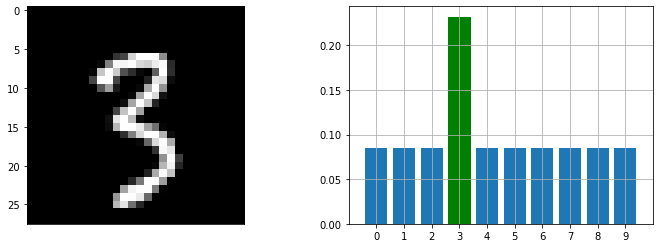

Predicted:3
True answer:3


In [24]:
import random

idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_digit(sample)

print(f"True answer:{test_y[idx]}")